In [4]:
options(warn=-1)

In [5]:
library('edgeR')
library('limma')

In [6]:
file_path = '/tmp/work/RCproject/GEO_singlecellexperiment.rds'
sce <- readRDS(file_path)
sce <- sce[, colData(sce)$Response != "partial"]
sce

class: SingleCellExperiment 
dim: 12165 410 
metadata(0):
assays(3): counts logcounts scalelogcounts
rownames(12165): A1CF A2M ... ZZEF1 ZZZ3
rowData names(5): SYMBOL ENTREZID ENSEMBL gene_id gene_name
colnames(410): GSM3899156_GSE133057 GSM3899158_GSE133057 ...
  GSM6390461_GSE209746 GSM6390462_GSE209746
colData names(6): Response TRG ... Platform batch
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

In [7]:
response <- colData(sce)$Response
batch <- colData(sce)$batch

In [8]:
table(colData(sce)$batch)


    GSE133057     GSE145037     GSE150082     GSE190826     GSE209746 
           26            31            30           104            97 
GSE45404_GPL1 GSE45404_GPL2      GSE93375      GSE94104 
           38            42            19            23 

In [9]:
counts <- counts(sce)

In [10]:
d0 <- DGEList(counts)
d0 <- calcNormFactors(d0)

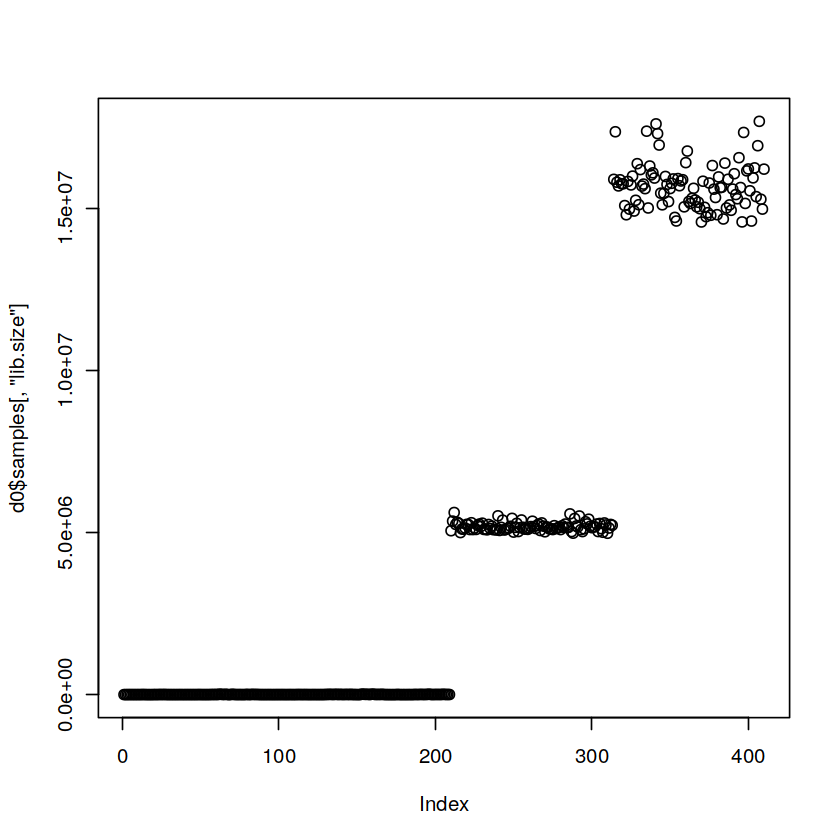

In [11]:
plot(d0$samples[,'lib.size'])

In [12]:
cutoff <-1
drop <- which(apply(edgeR::cpm(d0), 1, max) < cutoff)

# Handle case where no genes meet the condition
if (length(drop) > 0) {
  d <- d0[-drop, ]
} else {
  d <- d0  # No genes to drop
}

dim(d)  # Number of genes left

[1] 12165   410

In [13]:
batch <- factor(unlist(batch))
response <- factor(unlist(response))

In [14]:
head(batch)
head(response)

[1] GSE133057 GSE133057 GSE133057 GSE133057 GSE133057 GSE133057
9 Levels: GSE133057 GSE145037 GSE150082 GSE190826 GSE209746 ... GSE94104

[1] yes yes yes no  no  no 
Levels: no yes

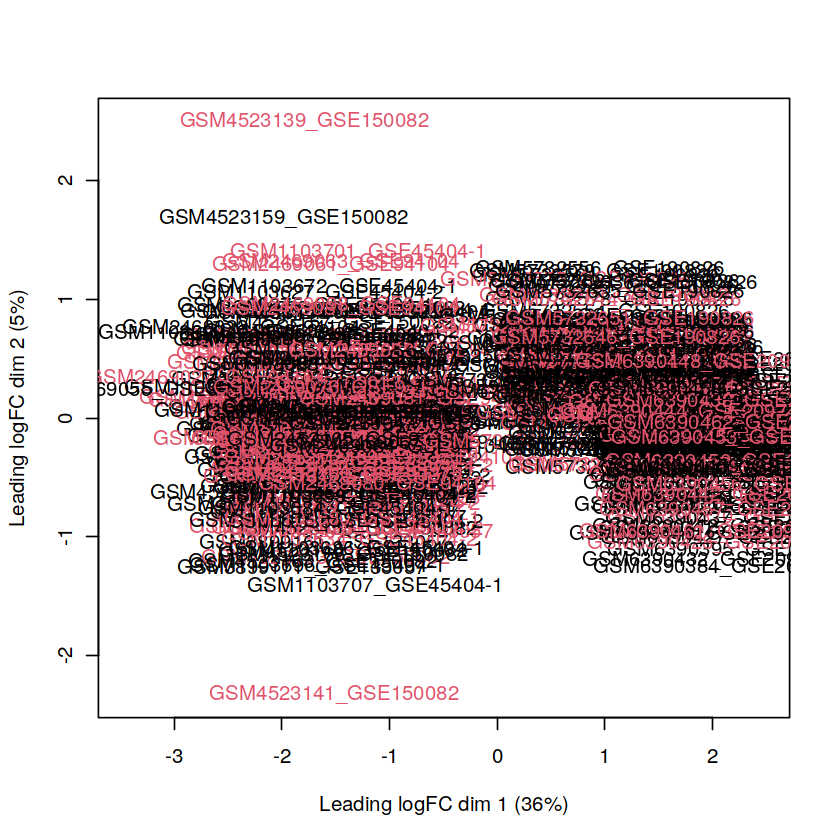

In [15]:
plotMDS(d, col = as.numeric(response))

,(Intercept),responseyes,batchGSE145037,batchGSE150082,batchGSE190826,batchGSE209746,batchGSE45404_GPL1,batchGSE45404_GPL2,batchGSE93375,batchGSE94104
1,1,1,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,0,0


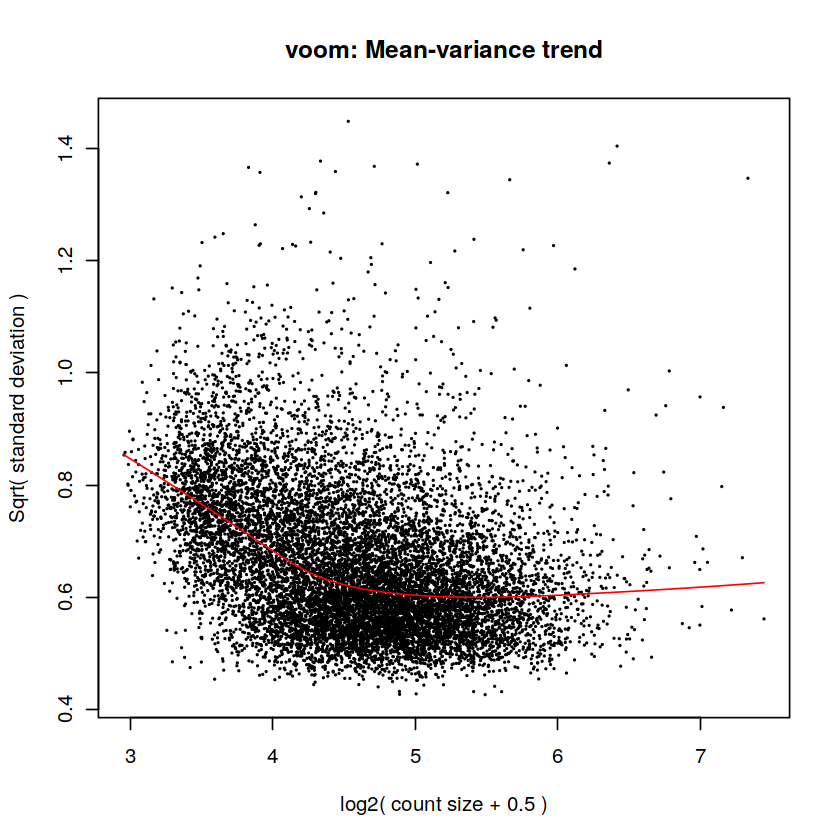

In [16]:
mm <- model.matrix(~ response + batch)
head(mm)
y <- voom(d, mm, plot = T)

In [17]:
fit <- lmFit(y, mm)
head(coef(fit))

,(Intercept),responseyes,batchGSE145037,batchGSE150082,batchGSE190826,batchGSE209746,batchGSE45404_GPL1,batchGSE45404_GPL2,batchGSE93375,batchGSE94104
A1CF,6.459901,-0.132285959,0.122293358,0.02697490,-0.02038951,-0.2214452,0.04234006,0.096407864,0.01133540,0.33804621
A2M,6.473862,0.023440232,0.014000751,0.02915955,1.80123694,2.5539186,-0.03918243,-0.002757793,-0.02089943,-0.17426416
A2ML1,6.511198,-0.080071772,0.096719453,-0.00964866,-2.50380214,-3.8753947,-0.06158591,-0.008003772,0.01985838,0.08105850
A4GALT,6.518088,-0.002597402,-0.072680157,-0.04079291,-1.53018541,-1.7941869,-0.05094725,-0.075359392,-0.08190862,-0.20163131
AAAS,6.458377,-0.008703029,-0.003110555,-0.03433499,-0.69264350,-0.6196894,-0.03880489,-0.010092432,0.12858205,0.20934987
AACS,6.447976,0.001858407,0.010448495,-0.02065917,0.39185050,0.4667779,-0.02958082,-0.002247980,0.09677937,0.05451658


In [18]:
contr <- makeContrasts(responseyes, levels = colnames(coef(fit)))
contr

,responseyes
Intercept,0
responseyes,1
batchGSE145037,0
batchGSE150082,0
batchGSE190826,0
batchGSE209746,0
batchGSE45404_GPL1,0
batchGSE45404_GPL2,0
batchGSE93375,0
batchGSE94104,0


In [19]:
tmp <- contrasts.fit(fit, contr)

In [20]:
tmp <- eBayes(tmp)

In [21]:
top.table <- topTable(tmp, sort.by = "P", n = Inf)
head(top.table, 20)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
PRSS3,-0.2694316,6.075626,-5.157613,3.922945e-07,0.004772262,5.7550897
CYP4V2,0.2200344,6.410596,4.701713,3.543450e-06,0.014882346,3.8757001
MBIP,0.2530638,5.883900,4.694145,3.670122e-06,0.014882346,3.8462341
AGO4,0.1594394,6.519113,4.408480,1.335387e-05,0.033872838,2.7482503
POLR1E,-0.1687396,6.001204,-4.370787,1.575608e-05,0.033872838,2.6080378
SLC7A1,-0.2628994,7.285237,-4.357374,1.670670e-05,0.033872838,2.5584025
ALG3,-0.1535977,6.160377,-4.070703,5.638113e-05,0.093023611,1.5306620
RFT1,-0.1274762,6.145976,-4.027894,6.721418e-05,0.093023611,1.3826502
TRAPPC8,0.1638135,6.591284,4.022109,6.882141e-05,0.093023611,1.3627594


In [22]:
length(which(top.table$adj.P.Val < 0.05))

[1] 6